In [22]:
from click.core import batch
from mpmath.identification import transforms
!pip install torch torchvision matplotlib
!pip install numpy


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\eddja\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\eddja\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
transform = transforms.ToTensor() #Tansform images to pytorch tensor

"""
transform = transforms.Compose([ - normalizing to [-1, 1] for use of tanh activation function
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])
"""

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=64)

In [8]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images)) #should be 0 and 1  dataset was normalized by transforms.ToTensor()

tensor(0.) tensor(1.)


In [37]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder: (N, 1, 28, 28) → (N, 128, 1, 1)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),   # (N, 16, 14, 14)
            nn.ReLU(),

            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # (N, 32, 7, 7)
            nn.ReLU(),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # (N, 64, 4, 4)
            nn.ReLU(),

            nn.Conv2d(64, 128, 4),                      # (N, 128, 1, 1)
        )

        # Decoder: (N, 128, 1, 1) → (N, 1, 28, 28)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4),             # (N, 64, 4, 4)
            nn.ReLU(),

            nn.ConvTranspose2d(
                64, 32, 3, stride=2, padding=1, output_padding=0
            ),                                          # (N, 32, 7, 7)
            nn.ReLU(),

            nn.ConvTranspose2d(
                32, 16, 3, stride=2, padding=1, output_padding=1
            ),                                          # (N, 16, 14, 14)
            nn.ReLU(),

            nn.ConvTranspose2d(
                16, 1, 3, stride=2, padding=1, output_padding=1
            ),                                          # (N, 1, 28, 28)

            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


In [38]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=1e-5)

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs_count = 10
outputs = []

for epoch in range(epochs_count):
    model.train()

    for img, _ in data_loader:
        img = img.to(device)

        recon = model(img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch + 1}, Loss: {loss.item():.4f}")

    # store last batch safely (CPU, no gradients)
    outputs.append((
        epoch,
        img.detach().cpu(),
        recon.detach().cpu()
    ))


Epoch: 1, Loss: 0.0165
Epoch: 2, Loss: 0.0091
Epoch: 3, Loss: 0.0070
Epoch: 4, Loss: 0.0061
Epoch: 5, Loss: 0.0053
Epoch: 6, Loss: 0.0048
Epoch: 7, Loss: 0.0046
Epoch: 8, Loss: 0.0043
Epoch: 9, Loss: 0.0041
Epoch: 10, Loss: 0.0038


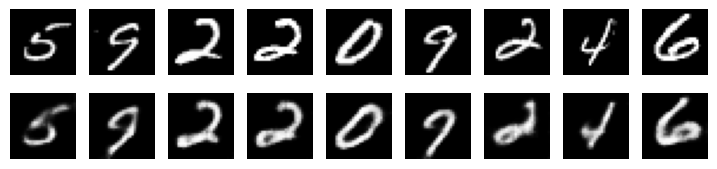

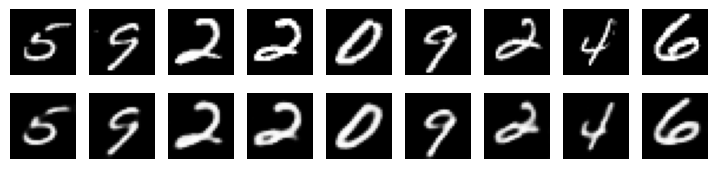

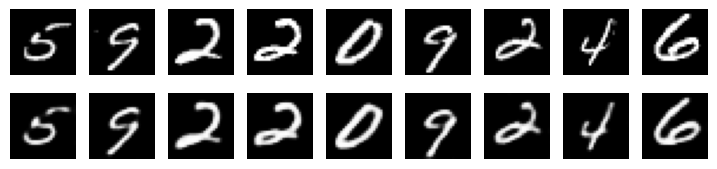

In [40]:
for k in range(0, epochs_count, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()

    img = outputs[k][1].numpy()
    recon = outputs[k][2].numpy()

    # Original images (top row)
    for i, item in enumerate(img):
        if i >= 9:
            break
        plt.subplot(2, 9, i + 1)
        plt.imshow(item.reshape(28, 28))
        plt.axis("off")

    # Reconstructed images (bottom row)
    for i, item in enumerate(recon):
        if i >= 9:
            break
        plt.subplot(2, 9, 9 + i + 1)
        plt.imshow(item.reshape(28, 28))
        plt.axis("off")

    plt.show()
